# Covid-19 US Timeseries Data:

### Data Source: **2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering**

Link: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import datetime

from lib import get_or_update_source_data

In [2]:
get_or_update_source_data()

Updating source data


In [3]:
df = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv') 

In [4]:
us_states_by_county = df[(df["Country/Region"]=='US') & (df["Province/State"].str.contains(','))]
us_states_by_county

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20
213,"Kitsap, WA",US,47.6477,-122.6413,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
214,"Solano, CA",US,38.3105,-121.9018,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
215,"Santa Cruz, CA",US,37.0454,-121.9580,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
216,"Napa, CA",US,38.5025,-122.2654,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
217,"Ventura, CA",US,34.3705,-119.1391,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,"Socorro, NM",US,33.8837,-106.7235,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
400,"Bernalillo, NM",US,35.0178,-106.6291,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
401,"Oakland, MI",US,42.5922,-83.3362,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
402,"Wayne, MI",US,42.2791,-83.3362,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


### On 3/10/20, data stopped being reported by county and began reporting at the state level:

Source: https://github.com/CSSEGISandData/COVID-19/issues/382

In [5]:
us_states = df[(df["Country/Region"]=='US') & (df["Province/State"].str.contains(',').apply(lambda x: not x))]
us_states

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20
100,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,0,0,0,0,0,0,0,267,366,NaN
101,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,0,0,0,0,0,0,0,173,220,NaN
102,California,US,36.1162,-119.6816,0,0,0,0,0,0,...,0,0,0,0,0,0,0,144,177,NaN
103,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,...,0,0,0,0,0,0,0,92,95,NaN
104,Diamond Princess,US,35.4437,139.6380,0,0,0,0,0,0,...,45,45,45,45,45,45,45,46,46,NaN
105,Grand Princess,US,37.6489,-122.6655,0,0,0,0,0,0,...,0,0,0,0,21,21,21,21,21,NaN
106,Georgia,US,33.0406,-83.6431,0,0,0,0,0,0,...,0,0,0,0,0,0,0,17,23,NaN
107,Colorado,US,39.0598,-105.3111,0,0,0,0,0,0,...,0,0,0,0,0,0,0,15,34,NaN
108,Florida,US,27.7663,-81.6868,0,0,0,0,0,0,...,0,0,0,0,0,0,0,15,28,NaN
109,New Jersey,US,40.2989,-74.5210,0,0,0,0,0,0,...,0,0,0,0,0,0,0,15,23,NaN


In [6]:
states_sum_by_county = us_states_by_county.sum().to_frame().drop(["Province/State", "Country/Region", "Lat", "Long"])
states_sum_by_county = states_sum_by_county[(states_sum_by_county[0]!=0)]
states_sum_by_county.columns = ["Confirmed Cases"]
states_sum_by_county.index = [datetime.datetime.strptime(index, "%m/%d/%y") for index in states_sum_by_county.index]
states_sum_by_county.loc[:'2020-03-9']

,Confirmed Cases
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5
2020-01-27,5
2020-01-28,5
2020-01-29,5
2020-01-30,5
2020-01-31,7


In [7]:
states_sum = us_states.sum().to_frame().drop(["Province/State", "Country/Region", "Lat", "Long"])
states_sum = states_sum[(states_sum[0]!=0)]
states_sum.columns = ["Confirmed Cases"]
states_sum.index = [datetime.datetime.strptime(index, "%m/%d/%y") for index in states_sum.index]
states_sum.loc['2020-03-10':]

,Confirmed Cases
2020-03-10,959
2020-03-11,1281


In [8]:
totals = pd.concat([states_sum_by_county.loc[:'2020-03-9'], states_sum.loc['2020-03-10':]], axis=0)

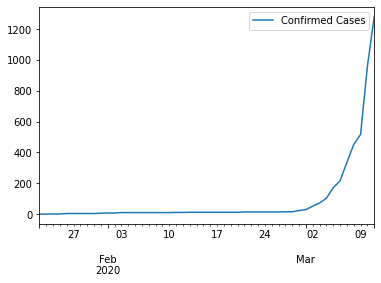

In [9]:
totals.plot()

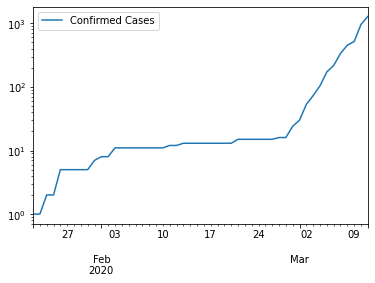

In [10]:
totals.plot(logy=True)

## Projections:

In [11]:
totals = totals.loc['2020-02-23':]

In [12]:
m, b = np.polyfit(list(range(len(totals.index))), np.log(list(totals['Confirmed Cases'])), 1)

/Users/phil/.local/share/virtualenvs/covid-19-us-timeseries-CRf528SM/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


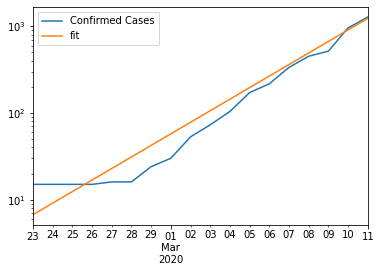

In [13]:
xs = np.linspace(0.0, float(len(totals.index)), len(totals.index))
ys = np.exp(m*xs + b)
totals['fit'] = ys
totals.plot(logy=True)

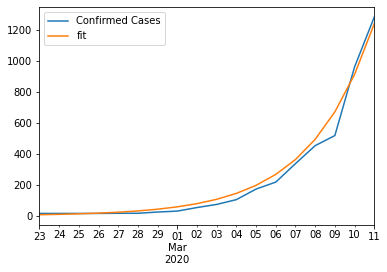

In [14]:
totals.plot()

In [15]:
projection = pd.DataFrame([np.exp(m*(len(totals.index) + n) + b) for n in range(0,30)]).round()
projection.index = [datetime.date.today() + datetime.timedelta(days=x) for x in range(0,30)]
projection.columns = ['Projected Cases']
projection

,Projected Cases
2020-03-12,1238.0
2020-03-13,1654.0
2020-03-14,2211.0
2020-03-15,2954.0
2020-03-16,3948.0
2020-03-17,5276.0
2020-03-18,7051.0
2020-03-19,9423.0
2020-03-20,12594.0
2020-03-21,16830.0


### Millions of people: Y Axis

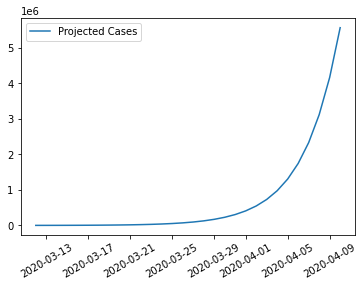

In [16]:
projection.plot(rot=30)